<a href="https://colab.research.google.com/github/jafarbakhshaliyev/Amex_Default_Prediction/blob/main/Amex_creditcard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-block alert-info">
$$\Huge{\color{blue}{\textbf{💳 American Express - Default Prediction 💳}}}$$
</div>

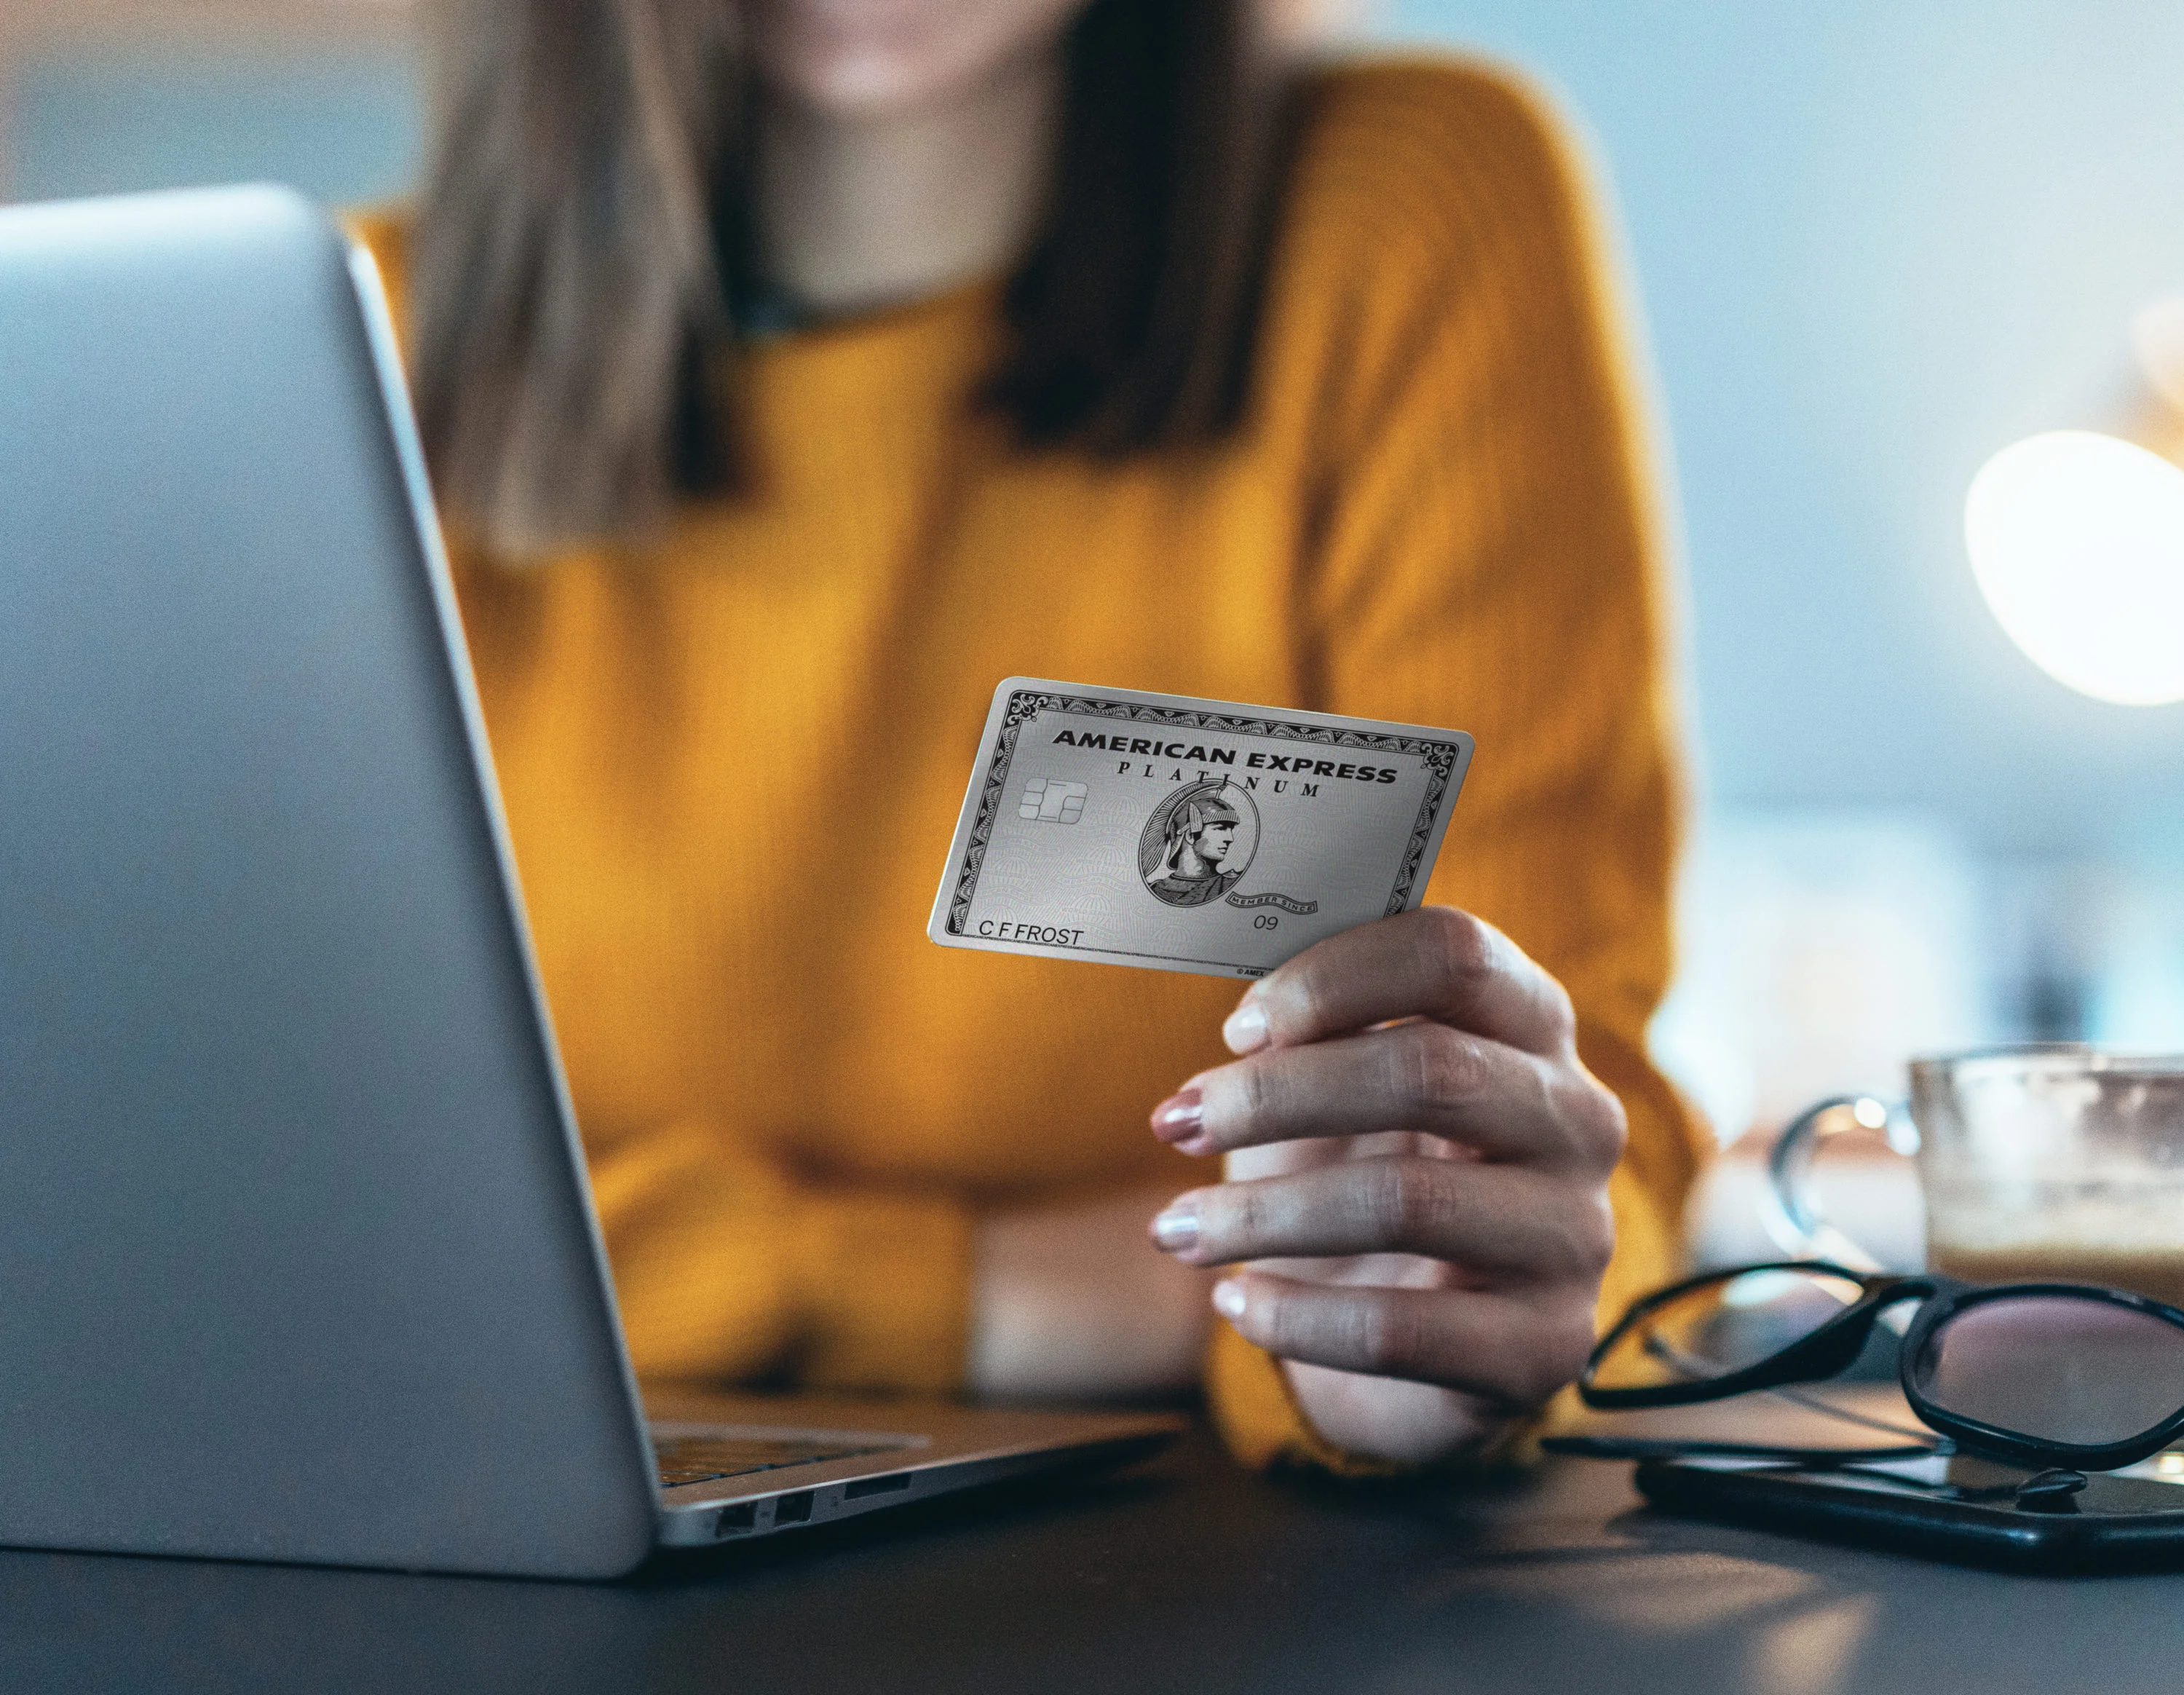

<div class="alert alert-block alert-info">
$\Large{\color{blue}{\textbf{📌 Importing Modules:}}}$
</div>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, mean_squared_error, precision_score, recall_score, precision_recall_curve, make_scorer, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.manifold import TSNE
import lightgbm as lgb
from sklearn import preprocessing
import gc
import pickle5 as pickle
import gzip
import optuna
from openTSNE import TSNE
import examples
import joblib
pd.set_option("display.max_columns", None)

<div class="alert alert-block alert-info">
$\Large{\color{blue}{\textbf{📌 Functions:}}}$
</div>

In [13]:
def pie_chart(df,col,title):
  """
  This function plots a pie chart with the specification below based on column (param col).
  """
  colors = ["#0048ba", '#485aa4']
  fig, ax = plt.subplots(1,2,figsize=(16, 8))
  fig.suptitle(title, size = 20)
  labels = list(df[col].value_counts().index)
  values = df[col].value_counts()
  ax[0].pie(values,colors=colors,explode=(.05,0),startangle=60,labels=labels, autopct='%1.0f%%', pctdistance=0.6)
  sns.countplot(x=col, data=df, hue=col,palette=colors, ax=ax[1])
  ax[0].add_artist(plt.Circle((0,0),0.4,fc='white'))
  plt.show()    

In [14]:
def amex(preds, train_data) -> float:
  """
  It is a custom metric which takes prediction and true target values and returns weighted of
  gini and top_four scores.
  """
  y_true=train_data.get_label()
  y_pred = 1. / (1. + np.exp(-preds))

  def amex_metric_mod(y_true, y_pred):

      labels     = np.transpose(np.array([y_true, y_pred]))
      labels     = labels[labels[:, 1].argsort()[::-1]]
      weights    = np.where(labels[:,0]==0, 20, 1)
      cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
      top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

      gini = [0,0]
      for i in [1,0]:
          labels         = np.transpose(np.array([y_true, y_pred]))
          labels         = labels[labels[:, i].argsort()[::-1]]
          weight         = np.where(labels[:,0]==0, 20, 1)
          weight_random  = np.cumsum(weight / np.sum(weight))
          total_pos      = np.sum(labels[:, 0] *  weight)
          cum_pos_found  = np.cumsum(labels[:, 0] * weight)
          lorentz        = cum_pos_found / total_pos
          gini[i]        = np.sum((lorentz - weight_random) * weight)

      return 0.5 * (gini[1]/gini[0] + top_four)
  return 'amex', amex_metric_mod(y_true,y_pred), True

In [15]:
def reduce_mem_usage(df):
    """
    Reduces memory usage for all columns in a Pandas DataFrame
    """
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")

    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings                       
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int32)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
               IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    else:
                        df[col] = df[col].astype(np.uint32)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    else:
                        df[col] = df[col].astype(np.int32)
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    # Print final result
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is after reduction is:",mem_usg," MB")
    return df, NAlist

<div class="alert alert-block alert-info">
$\Large{\color{blue}{\textbf{📌 Accessing to the Data:}}}$
</div>

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c amex-default-prediction
! unzip /content/amex-default-prediction.zip

100% 20.5G/20.5G [01:34<00:00, 263MB/s]
100% 20.5G/20.5G [01:34<00:00, 234MB/s]
Archive:  /content/amex-default-prediction.zip
  inflating: sample_submission.csv   
  inflating: test_data.csv           
  inflating: train_data.csv          
  inflating: train_labels.csv        


In [ ]:
train_data = pd.read_csv('./train_data.csv', iterator = True, chunksize= 1000)
train_data = pd.concat(train_data, ignore_index = True)

In [ ]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,NaN,NaN,0.000630,0.080986,0.708906,0.170600,0.006204,0.358587,0.525351,0.255736,NaN,0.063902,0.059416,0.006466,0.148698,1.335856,0.008207,0.001423,0.207334,0.736463,0.096219,NaN,0.023381,0.002768,0.008322,1.001519,0.008298,0.161345,0.148266,0.922998,0.354596,0.152025,0.118075,0.001882,0.158612,0.065728,0.018385,0.063646,0.199617,0.308233,0.016361,0.401619,0.091071,CR,O,0.007126,0.007665,NaN,0.652984,0.008520,NaN,0.004730,6.0,0.272008,0.008363,0.515222,0.002644,0.009013,0.004808,0.008342,0.119403,0.004802,0.108271,0.050882,NaN,0.007554,0.080422,0.069067,NaN,0.004327,0.007562,NaN,0.007729,0.000272,0.001576,0.004239,0.001434,NaN,0.002271,0.004061,0.007121,0.002456,0.002310,0.003532,0.506612,0.008033,1.009825,0.084683,0.003820,0.007043,0.000438,0.006452,0.000830,0.005055,NaN,0.0,0.005720,0.007084,NaN,0.000198,0.008907,NaN,1,0.002537,0.005177,0.006626,0.009705,0.007782,0.002450,1.001101,0.002665,0.007479,0.006893,1.503673,1.006133,0.003569,0.008871,0.003950,0.003647,0.004950,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1.008691,1.004587,0.893734,NaN,0.670041,0.009968,0.004572,NaN,1.008949,2.0,NaN,0.004326,NaN,NaN,NaN,1.007336,0.210060,0.676922,0.007871,1.0,0.238250,0.0,4.0,0.232120,0.236266,0.0,0.702280,0.434345,0.003057,0.686516,0.008740,1.0,1.003319,1.007819,1.000080,0.006805,NaN,0.002052,0.005972,NaN,0.004345,0.001535,NaN,NaN,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,NaN,NaN,0.002526,0.069419,0.712795,0.113239,0.006206,0.353630,0.521311,0.223329,NaN,0.065261,0.057744,0.001614,0.149723,1.339794,0.008373,0.001984,0.202778,0.720886,0.099804,NaN,0.030599,0.002749,0.002482,1.009033,0.005136,0.140951,0.143530,0.919414,0.326757,0.156201,0.118737,0.001610,0.148459,0.093935,0.013035,0.065501,0.151387,0.265026,0.017688,0.406326,0.086805,CR,O,0.002413,0.007148,NaN,0.647093,0.002238,NaN,0.003879,6.0,0.188970,0.004030,0.509048,0.004193,0.007842,0.001283,0.006524,0.140611,0.000094,0.101018,0.040469,NaN,0.004832,0.081413,0.074166,NaN,0.004203,0.005304,NaN,0.001864,0.000979,0.009896,0.007597,0.000509,NaN,0.009810,0.000127,0.005966,0.000395,0.001327,0.007773,0.500855,0.000760,1.009461,0.081843,0.000347,0.007789,0.004311,0.002332,0.009469,0.003753,NaN,0.0,0.007584,0.006677,NaN,0.001142,0.005907,NaN,1,0.008427,0.008979,0.001854,0.009924,0.005987,0.002247,1.006779,0.002508,0.006827,0.002837,1.503577,1.005791,0.000571,0.000391,0.008351,0.008850,0.003180,0.902135,0.136333,0.919876,0.975624,0.004561,0.786007,1.000084,1.004118,0.906841,NaN,0.668647,0.003921,0.004654,NaN,1.003205,2.0,NaN,0.008707,NaN,NaN,NaN,1.007653,0.184093,0.822281,0.003444,1.0,0.247217,0.0,4.0,0.243532,0.241885,0.0,0.707017,0.430501,0.001306,0.686414,0.000755,1.0,1.008394,1.004333,1.008344,0.004407,NaN,0.001034,0.004838,NaN,0.

In [ ]:
train_data, na_list_train = reduce_mem_usage(train_data)

Memory usage of properties dataframe is : 8018.308303833008  MB
Memory usage of properties dataframe is after reduction is: 3919.475766181946  MB


In [ ]:
train_data.shape

(5531451, 190)

In [ ]:
train_data.to_pickle('/content/drive/MyDrive/train_org.pkl',compression = 'gzip')

In [ ]:
test_data = pd.read_csv('./test_data.csv', iterator = True, chunksize= 1000)
test_data = pd.concat(test_data, ignore_index = True)

In [ ]:
test_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631315,0.001912,0.010728,0.814497,0.007547,0.168651,0.009971,0.002347,0.113189,NaN,0.007584,0.116402,0.004483,0.009517,0.005178,NaN,0.474383,0.626467,NaN,0.174591,1.250677,1.003925,NaN,0.008718,0.001013,0.103590,0.119043,NaN,-0.002919,NaN,0.002771,0.004416,1.006875,1.005069,0.002810,0.105587,0.119198,0.321676,0.114564,NaN,NaN,0.003420,0.205898,NaN,0.010182,NaN,0.027472,0.588734,0.010489,1.881856,0.051811,CR,NaN,0.008294,0.008663,NaN,0.592103,0.009144,NaN,0.004986,NaN,0.190516,0.002675,0.409411,0.009990,NaN,0.005210,NaN,0.014684,0.004310,0.400602,1.134792,0.178862,0.959531,0.217694,0.204590,NaN,0.009799,0.007748,0.002916,0.006896,0.001656,0.004356,NaN,0.002008,NaN,0.002531,0.000348,0.001173,0.004170,0.004585,0.002291,0.508240,0.005093,1.002944,0.133804,0.004322,NaN,0.008857,0.004144,0.009563,0.006942,NaN,0.0,0.003684,0.009909,NaN,0.008908,0.002955,NaN,1,0.008999,0.003418,0.002200,0.003781,0.002948,0.004635,1.003810,0.006653,0.007474,0.000192,NaN,0.008761,0.000835,0.004389,0.004115,0.008442,0.009575,0.981078,0.134916,0.954664,0.971086,0.006562,0.002419,NaN,NaN,NaN,NaN,NaN,0.008146,0.007970,NaN,NaN,1.0,NaN,0.005124,NaN,NaN,NaN,1.004130,0.274203,0.004302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.006201,NaN,NaN,0.009664,NaN,NaN,NaN,NaN,0.007082,0.005957,NaN,NaN,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008281,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.587042,0.005275,0.011026,0.810848,0.001817,0.241389,0.000166,0.009132,0.123035,NaN,0.006646,0.134878,0.009497,0.026313,0.009029,NaN,0.473587,0.611682,NaN,0.177115,0.234169,1.009301,NaN,0.003146,0.005533,0.101239,0.120991,NaN,0.031222,NaN,0.006497,0.010003,1.005728,1.000432,0.000525,0.160562,0.121490,0.170728,0.184116,NaN,0.028347,0.007156,0.403270,0.014491,0.025130,NaN,0.054790,0.622886,0.021704,2.043278,0.057567,CR,NaN,0.002011,0.000835,NaN,0.590922,0.000165,NaN,0.001557,NaN,0.190172,0.001771,0.561424,0.008125,NaN,0.008394,0.000606,0.011945,0.002283,0.605887,0.208381,0.179502,0.961667,0.216526,0.206570,NaN,0.004549,0.003098,NaN,0.003682,0.005516,0.001506,0.001013,0.006444,NaN,0.007169,0.003077,0.005880,0.004056,0.009634,0.001225,0.508681,0.007319,1.003831,0.144626,0.005300,NaN,0.001477,0.002083,0.002234,0.005523,NaN,0.0,0.006410,0.007458,NaN,0.000843,0.007457,NaN,1,0.005120,0.002382,0.006557,0.001691,0.004449,0.000574,1.004629,0.004394,0.001169,0.006693,NaN,0.004318,0.008072,0.007888,0.007656,0.006347,0.006952,0.966995,0.138531,0.957019,0.975003,0.004611,0.006549,0.003031,0.008755,NaN,NaN,0.004698,0.000078,0.015463,NaN,1.007666,1.0,NaN,0.000610,NaN,NaN,NaN,1.004495,0.353639,0.276623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.003833,0.008782,0.005579,0.007441,NaN,0.007598,0.008074,NaN,0.007188,0.001253,NaN,NaN,NaN,NaN,NaN,0.000142,0.004940,0.009021,NaN,0.003695,0.003753,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.609056,0.003326,0.016390,1.004620,0.000114,0.266976,0.004196,0.004192,0

In [ ]:
test_data, na_list_test = reduce_mem_usage(test_data)

Memory usage of properties dataframe is : 16472.73861694336  MB
Memory usage of properties dataframe is after reduction is: 8052.1347942352295  MB


In [ ]:
test_data.shape

(11363762, 190)

In [ ]:
test_data.to_pickle('/content/drive/MyDrive/test_org.pkl',compression = 'gzip')

<div class="alert alert-block alert-info">
$\Large{\color{blue}{\textbf{📌 Data Exploration and Feature Engineering:}}}$
</div>

In [ ]:
delinquency_features = [col for col in train_data if col.startswith('D_')]
spend_features = [col for col in train_data if col.startswith('S_')]
payment_features = [col for col in train_data if col.startswith('P_')]
balance_features = [col for col in train_data if col.startswith('B_')]
risk_features = [col for col in train_data if col.startswith('R_')]
print('For Train Data:')
print("# of delinquency features:",len(delinquency_features))
print("# of spend features:",len(spend_features))
print("# of payment features:",len(payment_features))
print("# of balance features:",len(balance_features))
print("# of risk features:",len(risk_features))

For Train Data:
# of delinquency features: 96
# of spend features: 22
# of payment features: 3
# of balance features: 40
# of risk features: 28


In [ ]:
delinquency_featurest = [col for col in test_data if col.startswith('D_')]
spend_featurest = [col for col in test_data if col.startswith('S_')]
payment_featurest = [col for col in test_data if col.startswith('P_')]
balance_featurest = [col for col in test_data if col.startswith('B_')]
risk_featurest = [col for col in test_data if col.startswith('R_')]
print('For Test Data:')
print("# of delinquency features:",len(delinquency_featurest))
print("# of spend features:",len(spend_featurest))
print("# of payment features:",len(payment_featurest))
print("# of balance features:",len(balance_featurest))
print("# of risk features:",len(risk_featurest))

For Test Data:
# of delinquency features: 96
# of spend features: 22
# of payment features: 3
# of balance features: 40
# of risk features: 28


In [ ]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
num_features = [col for col in train_data.columns.to_list() if col not in cat_features]

In [ ]:
train_num_agg = train_data.groupby('customer_ID')[num_features].agg(['mean','std','min','max','last','first'])
train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
train_cat_agg = train_data.groupby('customer_ID')[cat_features].agg(['count','last','first','nunique'])
train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
train_data = pd.concat([train_num_agg,train_cat_agg], axis = 1)
train_data.to_pickle('/content/drive/MyDrive/train_eng.pkl',compression = 'gzip')
print('Feature Engineering and Pickling for Train Data are Done!')

Feature Engineering and Pickling for Train Data are Done!


In [ ]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
num_features = [col for col in test_data.columns.to_list() if col not in cat_features]

In [ ]:
test_num_agg = test_data.groupby('customer_ID')[num_features].agg(['mean','std','min','max','last','first'])
test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
test_cat_agg = test_data.groupby('customer_ID')[cat_features].agg(['count','last','first','nunique'])
test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
test_data = pd.concat([test_num_agg,test_cat_agg], axis = 1)
test_data.to_pickle('/content/drive/MyDrive/test_eng.pkl',compression = 'gzip')
print('Feature Engineering and Pickling for Test Data are Done!')

Feature Engineering and Pickling for Test Data are Done!


In [ ]:
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (458913, 1106)
Test Data Shape: (924621, 1106)


In [ ]:
with gzip.open("/content/drive/MyDrive/train_eng.pkl", 'rb') as tr:
    train_data = pickle.load(tr)
with gzip.open("/content/drive/MyDrive/test_eng.pkl", 'rb') as te:
    test_data = pickle.load(te)       

In [8]:
train_labels = pd.read_csv('/content/drive/MyDrive/train_labels.csv').set_index('customer_ID', drop=True)
train_data = pd.merge(train_data, train_labels, left_index=True, right_index=True)

In [9]:
x = train_data.drop(['target'],axis = 1)
y = train_data['target']
x_test = test_data
del test_data

In [10]:
cat_features = ['B_30_last', 'B_38_last', 'D_114_last', 'D_116_last', 'D_117_last', 'D_120_last', 'D_126_last', 'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last', 'B_30_first', 'B_38_first', 'D_114_first', 'D_116_first', 'D_117_first', 'D_120_first', 'D_126_first', 'D_63_first', 'D_64_first', 'D_66_first', 'D_68_first']
num_features = [col for col in x.columns.to_list() if col not in cat_features]

In [11]:
for col in cat_features:
  x[col] = x[col].astype('category')
for col in cat_features:
  x_test[col] = x_test[col].astype('category')

In [ ]:
# percentage of missing values per feature
print((x.isnull().sum() * 100 / x.shape[0]).sort_values(ascending=False))

D_64_last       1.150327
D_64_first      1.150327
R_13_std        1.115680
B_15_std        1.115680
D_111_std       1.115680
                  ...   
B_23_first      0.000000
D_73_mean       0.000000
D_73_min        0.000000
D_73_max        0.000000
D_68_nunique    0.000000
Length: 1106, dtype: float64


In [ ]:
# percentage of missing values per feature
print((x_test.isnull().sum() * 100 / x_test.shape[0]).sort_values(ascending=False))

D_64_last       2.296833
D_64_first      2.296833
R_13_std        0.630204
B_15_std        0.630204
D_111_std       0.630204
                  ...   
B_23_first      0.000000
D_73_mean       0.000000
D_73_min        0.000000
D_73_max        0.000000
D_68_nunique    0.000000
Length: 1106, dtype: float64


In [ ]:
pos, neg = train_data[train_data['target']==1].shape[0],train_data[train_data['target']==0].shape[0]
print('Number of positives: ', pos)
print('Number of negatives: ', neg)
print('Ratio of pos/total and neg/total:',pos/(pos+neg),'|',neg/(pos+neg))
print('Ratio of positive/negatives:',pos/neg)

Number of positives:  118828
Number of negatives:  340085
Ratio of pos/total and neg/total: 0.2589336105100531 | 0.7410663894899469
Ratio of positive/negatives: 0.3494067659555699


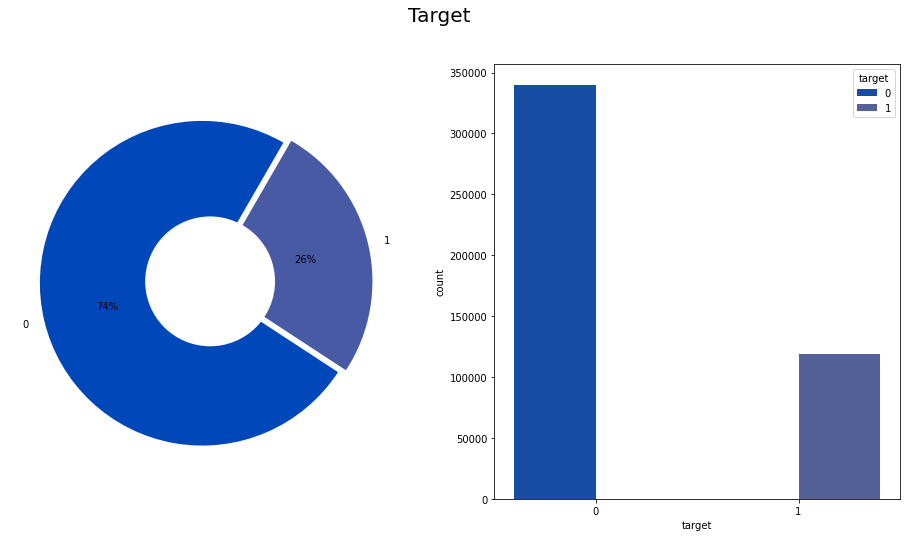

In [ ]:
pie_chart(train_data,'target','Target') 

In [12]:
del train_data

<div class="alert alert-block alert-info">
$\Large{\color{blue}{\textbf{📌 LightGBM - DART - HyperParameter Optimization:}}}$
</div>

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(x,y,test_size = 0.15, stratify = y, random_state = 34)

In [ ]:
lgb_train = lgb.Dataset(X_train, label= Y_train,free_raw_data=False)
lgb_test = lgb.Dataset(X_val,label= Y_val,free_raw_data=False)

def objective(trial):
                        
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'dart', 
        'seed': 32,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 50),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 50),
        'max_depth': trial.suggest_int('max_depth', -1, 60),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 3000),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'n_jobs': 40,
        'feature_pre_filter': False
    }

    lgbcv = lgb.train(param,
                      lgb_train,
                      valid_sets=lgb_test,
                      feval = amex,
                      verbose_eval=100,                   
                      categorical_feature = cat_features,                   
                      num_boost_round=1000                   
                  )
    
      
   
    cv_score = dict(lgbcv.best_score)
    cv_score = cv_score['valid_0']['amex']
    
    return cv_score


optuna.logging.set_verbosity(optuna.logging.WARNING) 
study = optuna.create_study(direction='maximize')  
study.optimize(objective)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['B_30_first', 'B_30_last', 'B_38_first', 'B_38_last', 'D_114_first', 'D_114_last', 'D_116_first', 'D_116_last', 'D_117_first', 'D_117_last', 'D_120_first', 'D_120_last', 'D_126_first', 'D_126_last', 'D_63_first', 'D_63_last', 'D_64_first', 'D_64_last', 'D_66_first', 'D_66_last', 'D_68_first', 'D_68_last']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	valid_0's binary_logloss: 0.303959	valid_0's amex: 0.762871
[200]	valid_0's binary_logloss: 0.258232	valid_0's amex: 0.771496
[300]	valid_0's binary_logloss: 0.234852	valid_0's amex: 0.777714
[400]	valid_0's binary_logloss: 0.230353	valid_0's amex: 0.781684
[500]	valid_0's binary_logloss: 0.223502	valid_0's amex: 0.786841
[600]	valid_0's binary_logloss: 0.220896	valid_0's amex: 0.789167
[700]	valid_0's binary_logloss: 0.22039	valid_0's amex: 0.78951
[800]	valid_0's binary_logloss: 0.21836	valid_0's amex: 0.79148
[900]	valid_0's binary_logloss: 0.218612	valid_0's amex: 0.791735
[1000]	valid_0's binary_logloss: 0.217621	valid_0's amex: 0.792718
[100]	valid_0's binary_logloss: 0.304891	valid_0's amex: 0.753537
[200]	valid_0's binary_logloss: 0.259854	valid_0's amex: 0.765176
[300]	valid_0's binary_logloss: 0.237986	valid_0's amex: 0.772436
[400]	valid_0's binary_logloss: 0.233321	valid_0's amex: 0.777932
[500]	valid_0's binary_logloss: 0.226548	valid_0's amex: 0.782094
[600]	valid_0

KeyboardInterrupt: ignored

In [ ]:
joblib.dump(study, "/content/drive/MyDrive/study.pkl")

['/content/drive/MyDrive/study.pkl']

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 151
Best trial:
  Value: 0.7960697668213128
  Params: 
    lambda_l1: 9.385370765838129e-07
    lambda_l2: 11.737348846036362
    max_depth: 40
    num_leaves: 44
    feature_fraction: 0.7480195061899545
    bagging_fraction: 0.8591975101585183
    bagging_freq: 28
    min_data_in_leaf: 2441
    learning_rate: 0.09502151239317932


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

<div class="alert alert-block alert-info">
$\Large{\color{blue}{\textbf{📌 LightGBM - DART - Implementation:}}}$
</div>

In [ ]:
kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 57)
test_pred = np.zeros(x_test.shape[0])
n = 0
for n_seed in range(4,9):
  scores = []
  for n_fold, (train_index, val_index) in enumerate(kf.split(x,y)):
      
      X_train = x.iloc[train_index]
      X_valid = x.iloc[val_index]
      Y_train = y.iloc[train_index]
      Y_valid = y.iloc[val_index]

      lgbm_params = {
                  'objective': 'binary',
                  'metric': 'binary_logloss',
                  'boosting': 'dart', 
                  'lambda_l1': 0,
                  'lambda_l2': 11.7,
                  'max_depth': 40,
                  'num_leaves': 45,
                  'feature_fraction': 0.7480195061899545,
                  'bagging_fraction': 0.8591975101585183,
                  'bagging_freq': 28,
                  'min_data_in_leaf': 2441,
                  'n_jobs': 40,
                  'learning_rate': 0.09502151239317932,
                  'seed': 2**n_seed}

    
        
      lgbm_train = lgb.Dataset(X_train, Y_train)
      lgbm_eval = lgb.Dataset(X_valid, Y_valid, reference=lgbm_train)

      model_lgbm = lgb.train(lgbm_params, lgbm_train, valid_sets = lgbm_eval, feval = amex,
                              num_boost_round = 6000, categorical_feature = cat_features,
                              verbose_eval = 100)
      scores.append(model_lgbm.best_score['valid_0']['amex'])

      #$if model_lgbm.best_score['valid_0']['amex'] > 0.799:
       # t_sne_score = model_lgbm.predict(x_test, num_iteration=model_lgbm.best_iteration, pred_leaf = True)

      if model_lgbm.best_score['valid_0']['amex'] > 0.7957:
        n += 1
        test_pred += model_lgbm.predict(x_test, num_iteration=model_lgbm.best_iteration)
      del X_train, X_valid, Y_train, Y_valid, lgbm_train, lgbm_eval
      gc.collect() 
  print(f'Seed # {n_seed} average score:', np.mean(scores))    

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['B_30_first', 'B_30_last', 'B_38_first', 'B_38_last', 'D_114_first', 'D_114_last', 'D_116_first', 'D_116_last', 'D_117_first', 'D_117_last', 'D_120_first', 'D_120_last', 'D_126_first', 'D_126_last', 'D_63_first', 'D_63_last', 'D_64_first', 'D_64_last', 'D_66_first', 'D_66_last', 'D_68_first', 'D_68_last']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	valid_0's binary_logloss: 0.252898	valid_0's amex: 0.769563
[200]	valid_0's binary_logloss: 0.226601	valid_0's amex: 0.783375
[300]	valid_0's binary_logloss: 0.224804	valid_0's amex: 0.785976
[400]	valid_0's binary_logloss: 0.220206	valid_0's amex: 0.789741
[500]	valid_0's binary_logloss: 0.21931	valid_0's amex: 0.790902
[600]	valid_0's binary_logloss: 0.218432	valid_0's amex: 0.790676
[700]	valid_0's binary_logloss: 0.218549	valid_0's amex: 0.789725
[800]	valid_0's binary_logloss: 0.217448	valid_0's amex: 0.790775
[900]	valid_0's binary_logloss: 0.217121	valid_0's amex: 0.790725
[1000]	valid_0's binary_logloss: 0.217023	valid_0's amex: 0.790636
[100]	valid_0's binary_logloss: 0.25197	valid_0's amex: 0.768648
[200]	valid_0's binary_logloss: 0.225392	valid_0's amex: 0.782659
[300]	valid_0's binary_logloss: 0.223702	valid_0's amex: 0.786037
[400]	valid_0's binary_logloss: 0.218969	valid_0's amex: 0.791729
[500]	valid_0's binary_logloss: 0.217957	valid_0's amex: 0.791583
[600]	valid

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['B_30_first', 'B_30_last', 'B_38_first', 'B_38_last', 'D_114_first', 'D_114_last', 'D_116_first', 'D_116_last', 'D_117_first', 'D_117_last', 'D_120_first', 'D_120_last', 'D_126_first', 'D_126_last', 'D_63_first', 'D_63_last', 'D_64_first', 'D_64_last', 'D_66_first', 'D_66_last', 'D_68_first', 'D_68_last']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	valid_0's binary_logloss: 0.254757	valid_0's amex: 0.768533
[200]	valid_0's binary_logloss: 0.23319	valid_0's amex: 0.778771
[300]	valid_0's binary_logloss: 0.223891	valid_0's amex: 0.786249
[400]	valid_0's binary_logloss: 0.222119	valid_0's amex: 0.78763
[500]	valid_0's binary_logloss: 0.219513	valid_0's amex: 0.789529
[600]	valid_0's binary_logloss: 0.218476	valid_0's amex: 0.789578
[700]	valid_0's binary_logloss: 0.21834	valid_0's amex: 0.789915
[800]	valid_0's binary_logloss: 0.217293	valid_0's amex: 0.790785
[900]	valid_0's binary_logloss: 0.217591	valid_0's amex: 0.791565
[1000]	valid_0's binary_logloss: 0.217251	valid_0's amex: 0.790958
[100]	valid_0's binary_logloss: 0.253486	valid_0's amex: 0.768667
[200]	valid_0's binary_logloss: 0.232156	valid_0's amex: 0.777622
[300]	valid_0's binary_logloss: 0.222963	valid_0's amex: 0.785787
[400]	valid_0's binary_logloss: 0.221206	valid_0's amex: 0.787831
[500]	valid_0's binary_logloss: 0.218283	valid_0's amex: 0.79153
[600]	valid_0

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['B_30_first', 'B_30_last', 'B_38_first', 'B_38_last', 'D_114_first', 'D_114_last', 'D_116_first', 'D_116_last', 'D_117_first', 'D_117_last', 'D_120_first', 'D_120_last', 'D_126_first', 'D_126_last', 'D_63_first', 'D_63_last', 'D_64_first', 'D_64_last', 'D_66_first', 'D_66_last', 'D_68_first', 'D_68_last']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	valid_0's binary_logloss: 0.245236	valid_0's amex: 0.770596
[200]	valid_0's binary_logloss: 0.227868	valid_0's amex: 0.781702
[300]	valid_0's binary_logloss: 0.223142	valid_0's amex: 0.785951
[400]	valid_0's binary_logloss: 0.221038	valid_0's amex: 0.788511
[500]	valid_0's binary_logloss: 0.219281	valid_0's amex: 0.788876
[600]	valid_0's binary_logloss: 0.218552	valid_0's amex: 0.789131
[700]	valid_0's binary_logloss: 0.218009	valid_0's amex: 0.790279
[800]	valid_0's binary_logloss: 0.217793	valid_0's amex: 0.790631
[900]	valid_0's binary_logloss: 0.21773	valid_0's amex: 0.790725
[1000]	valid_0's binary_logloss: 0.217193	valid_0's amex: 0.790618
[100]	valid_0's binary_logloss: 0.243784	valid_0's amex: 0.772377
[200]	valid_0's binary_logloss: 0.226563	valid_0's amex: 0.782722
[300]	valid_0's binary_logloss: 0.22213	valid_0's amex: 0.786492
[400]	valid_0's binary_logloss: 0.220075	valid_0's amex: 0.790535
[500]	valid_0's binary_logloss: 0.218094	valid_0's amex: 0.791605
[600]	valid

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['B_30_first', 'B_30_last', 'B_38_first', 'B_38_last', 'D_114_first', 'D_114_last', 'D_116_first', 'D_116_last', 'D_117_first', 'D_117_last', 'D_120_first', 'D_120_last', 'D_126_first', 'D_126_last', 'D_63_first', 'D_63_last', 'D_64_first', 'D_64_last', 'D_66_first', 'D_66_last', 'D_68_first', 'D_68_last']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	valid_0's binary_logloss: 0.254125	valid_0's amex: 0.769938
[200]	valid_0's binary_logloss: 0.229996	valid_0's amex: 0.779423
[300]	valid_0's binary_logloss: 0.226062	valid_0's amex: 0.782998
[400]	valid_0's binary_logloss: 0.221894	valid_0's amex: 0.785358
[500]	valid_0's binary_logloss: 0.220582	valid_0's amex: 0.786965
[600]	valid_0's binary_logloss: 0.218378	valid_0's amex: 0.788925
[700]	valid_0's binary_logloss: 0.218086	valid_0's amex: 0.789579
[800]	valid_0's binary_logloss: 0.217322	valid_0's amex: 0.790417
[900]	valid_0's binary_logloss: 0.217449	valid_0's amex: 0.790731
[1000]	valid_0's binary_logloss: 0.21692	valid_0's amex: 0.790969
[100]	valid_0's binary_logloss: 0.252552	valid_0's amex: 0.770337
[200]	valid_0's binary_logloss: 0.229004	valid_0's amex: 0.777993
[300]	valid_0's binary_logloss: 0.224575	valid_0's amex: 0.782713
[400]	valid_0's binary_logloss: 0.220348	valid_0's amex: 0.787059
[500]	valid_0's binary_logloss: 0.2193	valid_0's amex: 0.789488
[600]	valid_

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['B_30_first', 'B_30_last', 'B_38_first', 'B_38_last', 'D_114_first', 'D_114_last', 'D_116_first', 'D_116_last', 'D_117_first', 'D_117_last', 'D_120_first', 'D_120_last', 'D_126_first', 'D_126_last', 'D_63_first', 'D_63_last', 'D_64_first', 'D_64_last', 'D_66_first', 'D_66_last', 'D_68_first', 'D_68_last']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	valid_0's binary_logloss: 0.239567	valid_0's amex: 0.773299
[200]	valid_0's binary_logloss: 0.230062	valid_0's amex: 0.780694
[300]	valid_0's binary_logloss: 0.223868	valid_0's amex: 0.786208
[400]	valid_0's binary_logloss: 0.221264	valid_0's amex: 0.787057
[500]	valid_0's binary_logloss: 0.219492	valid_0's amex: 0.789067
[600]	valid_0's binary_logloss: 0.218219	valid_0's amex: 0.791413
[700]	valid_0's binary_logloss: 0.217982	valid_0's amex: 0.791174
[800]	valid_0's binary_logloss: 0.217702	valid_0's amex: 0.791638
[900]	valid_0's binary_logloss: 0.21764	valid_0's amex: 0.792269
[1000]	valid_0's binary_logloss: 0.21741	valid_0's amex: 0.790801
[100]	valid_0's binary_logloss: 0.238376	valid_0's amex: 0.774198
[200]	valid_0's binary_logloss: 0.229047	valid_0's amex: 0.780187
[300]	valid_0's binary_logloss: 0.22296	valid_0's amex: 0.785926
[400]	valid_0's binary_logloss: 0.22005	valid_0's amex: 0.787602
[500]	valid_0's binary_logloss: 0.218391	valid_0's amex: 0.790777
[600]	valid_0

In [ ]:
test_prediction = test_pred/n

In [ ]:
test_prediction

array([0.03079241, 0.00088999, 0.03929375, ..., 0.46358787, 0.24114359,
       0.05483371])

<div class="alert alert-block alert-info">
$\Large{\color{blue}{\textbf{📌 Visualization by T-distributed Stochastic Neighbor Embedding }}}$
</div>

In [13]:
kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 57)
for n_fold, (train_index, val_index) in enumerate(kf.split(x,y)):
    
    X_train = x.iloc[train_index]
    X_valid = x.iloc[val_index]
    Y_train = y.iloc[train_index]
    Y_valid = y.iloc[val_index]

    lgbm_params = {
                  'objective': 'binary',
                  'metric': 'binary_logloss',
                  'boosting': 'dart', 
                  'lambda_l1': 0,
                  'lambda_l2': 11.7,
                  'max_depth': 40,
                  'num_leaves': 45,
                  'feature_fraction': 0.7480195061899545,
                  'bagging_fraction': 0.8591975101585183,
                  'bagging_freq': 28,
                  'min_data_in_leaf': 2441,
                  'n_jobs': 40,
                  'learning_rate': 0.09502151239317932,
                  'seed': 32}

  
      
    lgbm_train = lgb.Dataset(X_train, Y_train)
    lgbm_eval = lgb.Dataset(X_valid, Y_valid, reference=lgbm_train)

    model_lgbm = lgb.train(lgbm_params, lgbm_train, valid_sets = lgbm_eval, feval = amex,
                            num_boost_round = 1000, categorical_feature = cat_features,
                            verbose_eval = 100)
    
    del X_train, Y_train, lgbm_train, lgbm_eval
    
    if model_lgbm.best_score['valid_0']['amex'] > 0.7997:
      features_tsne = model_lgbm.predict(X_valid, num_iteration=model_lgbm.best_iteration, pred_leaf = True)
      target_tsne = Y_valid
      del model_lgbm, X_valid, Y_valid
      break
    del model_lgbm, X_valid, Y_valid
    gc.collect()    

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['B_30_first', 'B_30_last', 'B_38_first', 'B_38_last', 'D_114_first', 'D_114_last', 'D_116_first', 'D_116_last', 'D_117_first', 'D_117_last', 'D_120_first', 'D_120_last', 'D_126_first', 'D_126_last', 'D_63_first', 'D_63_last', 'D_64_first', 'D_64_last', 'D_66_first', 'D_66_last', 'D_68_first', 'D_68_last']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	valid_0's binary_logloss: 0.254757	valid_0's amex: 0.768533
[200]	valid_0's binary_logloss: 0.23319	valid_0's amex: 0.778771
[300]	valid_0's binary_logloss: 0.223891	valid_0's amex: 0.786249
[400]	valid_0's binary_logloss: 0.222119	valid_0's amex: 0.78763
[500]	valid_0's binary_logloss: 0.219513	valid_0's amex: 0.789529
[600]	valid_0's binary_logloss: 0.218476	valid_0's amex: 0.789578
[700]	valid_0's binary_logloss: 0.21834	valid_0's amex: 0.789915
[800]	valid_0's binary_logloss: 0.217293	valid_0's amex: 0.790785
[900]	valid_0's binary_logloss: 0.217591	valid_0's amex: 0.791565
[1000]	valid_0's binary_logloss: 0.217251	valid_0's amex: 0.790958
[100]	valid_0's binary_logloss: 0.253486	valid_0's amex: 0.768667
[200]	valid_0's binary_logloss: 0.232156	valid_0's amex: 0.777622
[300]	valid_0's binary_logloss: 0.222963	valid_0's amex: 0.785787
[400]	valid_0's binary_logloss: 0.221206	valid_0's amex: 0.787831
[500]	valid_0's binary_logloss: 0.218283	valid_0's amex: 0.79153
[600]	valid_0

In [17]:
features_tsne.shape

(45891, 1000)

In [18]:
target_tsne

customer_ID
0001337ded4e1c2539d1a78ff44a457bd4a95caa55ba1730b2849b92ea687f9e    1
00067f4aed8cf43b16652c966860774f650420ef7a306fb9769f14858d87ba9f    1
0006a80d96aec1d178bf74adab6cbf9e4bf427a6ba264fefecd53a4c1233cd21    1
0007138953c25a3a7d8f48cf60dd6e9ca4a77d9e945a443f986062a95f795c4d    0
0008c2f297e1b00bf567c0d2c25f3e3b356f9a3088d2bf47aaaa724d26df8787    1
                                                                   ..
fffcae1af226772f35143cd002489b2c99a0f4acdd593210b0e6f32dae1074d9    0
fffe0f90c85547c9a30d49afdc0f501523e55eec15399d0f298b3892d819821a    1
fffe39594fad367d9eb8ae18537b56b0739c4cc3ab9810f8642d49ec45e60c62    1
fffee847c5c1af7dbdd36d98fea882893256c422cde86cc927c7cce6e958dab4    0
ffff39cc22a375d07369980d02d617883dd28ad81a6aa36d506127604c66301c    0
Name: target, Length: 45891, dtype: int64

In [27]:
tsne = TSNE(
    perplexity=200,
    n_jobs=40,
    random_state=42,
    verbose=True
)

In [28]:
embedding = tsne.fit(features_tsne[:,:100])

--------------------------------------------------------------------------------
TSNE(n_jobs=40, perplexity=200, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 600 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 20.13 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 3.37 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.23 seconds
===> Running optimization with exaggeration=12.00, lr=3824.25 for 250 iterations...
Iteration   50, KL divergence 4.3687, 50 iterations in 4.7564 sec
Iteration  100, KL divergence 4.0913, 50 iterations in 4.8129 sec
Iteration  150, KL divergence 4.0494, 50 iterations in 4.8416 sec
Iteration  200, KL divergence 4.0372, 50 iterations in 4.8134 sec
Iteration  250, KL divergence 4.0305, 50 iterations in 4.8179 sec
   --> Time elapsed: 24.05 seconds
===> Running optimization with exaggeration=1.00

In [29]:
embedding

TSNEEmbedding([[  7.58624382,  -3.50397315],
               [ 14.87381095,  -2.59444596],
               [  7.8523697 ,  -3.89750433],
               ...,
               [ 18.81894878,  -6.22966753],
               [-11.6955781 ,   0.15210488],
               [  5.74849917,  17.85344838]])

In [39]:
df = pd.DataFrame()
df["y"] = target_tsne
df["t-SNE axis 1"] = embedding[:,0]
df["t-SNE axis 2"] = embedding[:,1]

[Text(0.5, 1.0, 't-SNE of first 100 LGB tree indices')]

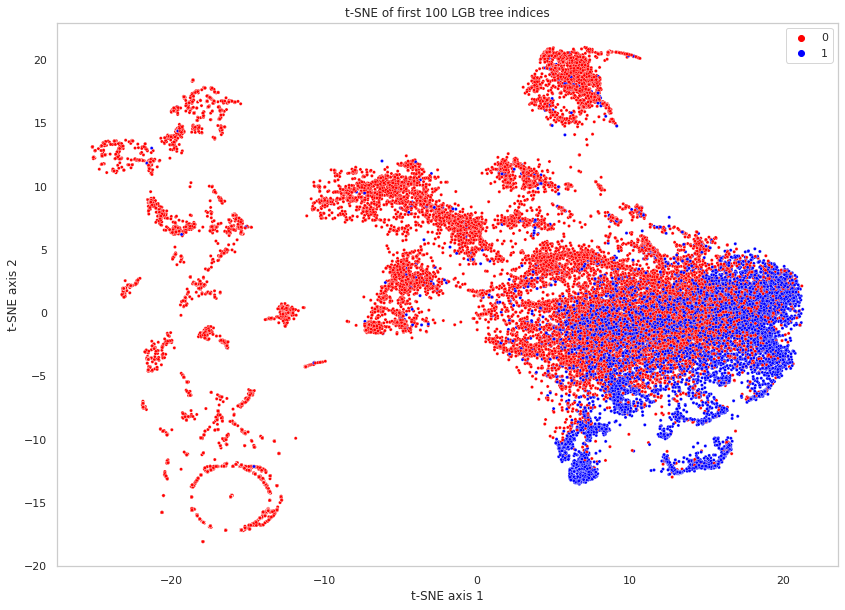

In [40]:
sns.set(rc={"figure.figsize":(14, 10)}) 
sns.set_style("whitegrid", {'axes.grid' : False})
palette = sns.color_palette("bright")
sns.scatterplot(x="t-SNE axis 1", y="t-SNE axis 2", hue=df.y.tolist(), 
            palette=sns.blend_palette(['red', 'blue'], 2),
                data=df, s = 10).set(title="t-SNE of first 100 LGB tree indices") 

In [32]:
embedding2 = tsne.fit(features_tsne)

--------------------------------------------------------------------------------
TSNE(n_jobs=40, perplexity=200, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 600 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 40.26 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 2.74 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.93 seconds
===> Running optimization with exaggeration=12.00, lr=3824.25 for 250 iterations...
Iteration   50, KL divergence 4.5436, 50 iterations in 4.1529 sec
Iteration  100, KL divergence 4.4137, 50 iterations in 4.0336 sec
Iteration  150, KL divergence 4.4115, 50 iterations in 4.1549 sec
Iteration  200, KL divergence 4.4114, 50 iterations in 4.1170 sec
Iteration  250, KL divergence 4.4114, 50 iterations in 4.0777 sec
   --> Time elapsed: 20.54 seconds
===> Running optimization with exaggeration=1.00

In [33]:
df = pd.DataFrame()
df["y"] = target_tsne
df["t-SNE axis 1"] = embedding2[:,0]
df["t-SNE axis 2"] = embedding2[:,1]

[Text(0.5, 1.0, 't-SNE of first 1000 LGB tree indices')]

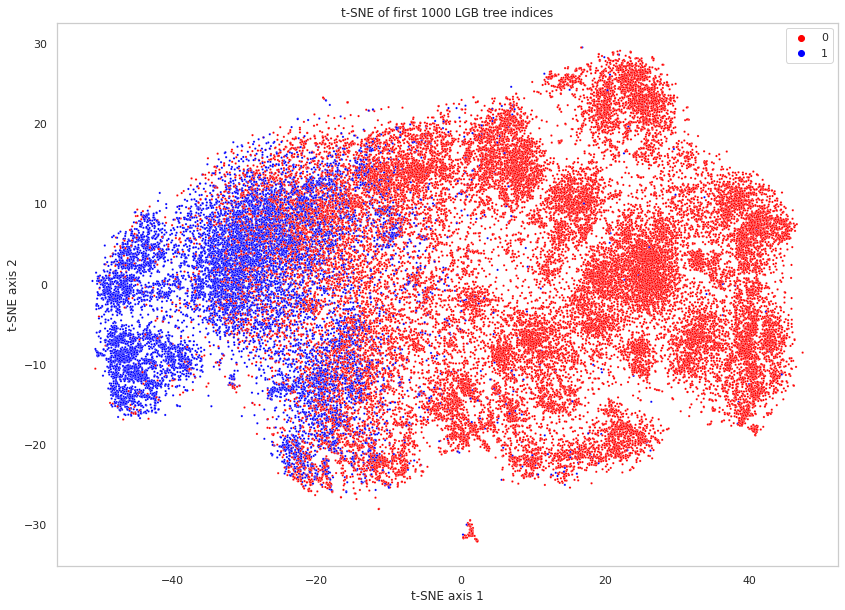

In [38]:
sns.set(rc={"figure.figsize":(14, 10)}) 
sns.set_style("whitegrid", {'axes.grid' : False})
palette = sns.color_palette("bright")
sns.scatterplot(x="t-SNE axis 1", y="t-SNE axis 2", hue=df.y.tolist(), 
            palette=sns.blend_palette(['red', 'blue'], 2),
                data=df, s = 5).set(title="t-SNE of first 1000 LGB tree indices") 

<div class="alert alert-block alert-info">
$\Large{\color{blue}{\textbf{📌 Submission:}}}$
</div>

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submission['prediction'] = test_prediction

In [ ]:
submission

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.030792
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000890
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.039294
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.311146
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.816337
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.010237
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.794179
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.463588
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.241144


In [ ]:
submission.to_csv('./submission.csv',index = False)